### <strong>主題:
啤酒評論評分預測 - 回歸模型建構
### <strong>說明:
完成了先前的課程之後，我們了解到有些問題其實是比較適合回歸模型的，比方說評分預測的問題 <br />
，因此我們這次以回歸模型，重新評估其各項屬性(apperance, aroma, overall, palate, taste)得分<br />
。另外，啤酒問題為多標籤問題(multi-label regression)，也必須特別注意。
### <strong>題目
1. 參照前次分類模型的結構，將分類模型修改為回歸模型<br />
(完成底下的BeerDataset與create_data_loader)
2. 修改完後，進行模型訓練，確認所修改的架構不會產生錯誤。

#### <strong>提示1: 若同學因GPU限制無法快速訓練，可以考慮調低訓練回合數，MAX_LEN，或選擇較小的bert模型。

In [1]:
import torch
import transformers
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from transformers import DistilBertModel, DistilBertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup

In [2]:
PRE_TRAINED_MODEL_NAME = "distilbert-base-cased"
BATCH_SIZE = 8
MAX_LEN = 128
EPOCHS = 10

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
TOKENIZER = DistilBertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [3]:
class BeerDataset(Dataset):
    """
    將資料集轉換為後續data DataLoader 需求的 pytorch Dataset形式
    Convert beer review dataframe into torch dataset instance
    """
    def __init__(self,
                 comments,
                 apperance_target,
                 aroma_target,
                 overall_target,
                 palate_target,
                 taste_target, max_len):
        self.comments = comments
        self.apperance_target = apperance_target
        self.aroma_target = aroma_target
        self.overall_target = overall_target
        self.palate_target = palate_target
        self.taste_target = taste_target
        self.max_len = max_len

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, item):
        comment = str(self.comments[item])
        apperance_target = self.apperance_target[item]
        aroma_target = self.aroma_target[item]
        overall_target = self.overall_target[item]
        palate_target = self.palate_target[item]
        taste_target = self.taste_target[item]
        encoding = TOKENIZER.encode_plus(
            comment,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'comment': comment,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'apperance_target': torch.tensor(apperance_target, dtype=torch.float),
            'aroma_target': torch.tensor(aroma_target, dtype=torch.float),
            'overall_target': torch.tensor(overall_target, dtype=torch.float),
            'palate_target': torch.tensor(palate_target, dtype=torch.float),
            'taste_target': torch.tensor(taste_target, dtype=torch.float)
        }

In [4]:
def create_data_loader(dataframe, max_len, batch_size):
    """
    將pytorch Dataset形式資料集包裝為data DataLoader
    convert dataset to pytorch dataloader format object
    """
    dataset = BeerDataset(
        comments=dataframe["review/text"].values,
        apperance_target=dataframe["review/appearance"].values,
        aroma_target=dataframe["review/aroma"].values,
        overall_target=dataframe["review/overall"].values,
        palate_target=dataframe["review/palate"].values,
        taste_target=dataframe["review/taste"].values,
        max_len=max_len
    )
    return DataLoader(
        dataset,
        batch_size=batch_size
    )


In [5]:
class BeerRateRegressor(nn.Module):
    """
    啤酒評論評分回歸模型的主體
    Beer sentiment main model for review sentiment analyzer
    """
    def __init__(self):
        super(BeerRateRegressor, self).__init__()
        self.bert = DistilBertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.2)
        self.apperance_out = nn.Linear(self.bert.config.hidden_size, 1)
        self.aroma_out = nn.Linear(self.bert.config.hidden_size, 1)
        self.overall_out = nn.Linear(self.bert.config.hidden_size, 1)
        self.palate_out = nn.Linear(self.bert.config.hidden_size, 1)
        self.taste_out = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        (output,) = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = output[:,-1,:].squeeze(dim=1)
        
        apperance_output = self.apperance_out(pooled_output)
        aroma_output = self.aroma_out(pooled_output)
        overall_output = self.overall_out(pooled_output)
        palate_output = self.palate_out(pooled_output)
        taste_output = self.taste_out(pooled_output)
        return {
            "apperance": apperance_output,
            "aroma": aroma_output,
            "overall": overall_output,
            "palate": palate_output,
            "taste": taste_output,
        }

In [6]:
def train_epoch(model,
                data_loader,
                loss_fn,
                optimizer,
                scheduler,
                n_examples):
    """
    電影評論分類器的訓練主流程
    Main training process of bert sentiment classifier
    """
    model = model.train()
    losses = []
    for _d in tqdm(data_loader):
        input_ids = _d["input_ids"].to(DEVICE)
        attention_mask = _d["attention_mask"].to(DEVICE)
        apperance_target = _d["apperance_target"].to(DEVICE)
        aroma_target = _d["aroma_target"].to(DEVICE)
        overall_target = _d["overall_target"].to(DEVICE)
        palate_target = _d["palate_target"].to(DEVICE)
        taste_target = _d["taste_target"].to(DEVICE)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        apperance_loss = loss_fn(outputs["apperance"], apperance_target)
        aroma_loss = loss_fn(outputs["aroma"], aroma_target)
        overall_loss = loss_fn(outputs["overall"], overall_target)
        palate_loss = loss_fn(outputs["palate"], palate_target)
        taste_loss = loss_fn(outputs["taste"], taste_target)
   
        loss = apperance_loss + aroma_loss + overall_loss + palate_loss + taste_loss
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        torch.cuda.empty_cache()
        
    return np.mean(losses)

def eval_model(model,
               data_loader,
               loss_fn,
               n_examples):
    """
    電影評論分類器的訓練時每個epoch評估訓練效能主流程
    Main evaluate process in training of bert sentiment classifier
    """
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(DEVICE)
            attention_mask = d["attention_mask"].to(DEVICE)
            apperance_target = d["apperance_target"].to(DEVICE)
            aroma_target = d["aroma_target"].to(DEVICE)
            overall_target = d["overall_target"].to(DEVICE)
            palate_target = d["palate_target"].to(DEVICE)
            taste_target = d["taste_target"].to(DEVICE)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            apperance_loss = loss_fn(outputs["apperance"], apperance_target)
            aroma_loss = loss_fn(outputs["aroma"], aroma_target)
            overall_loss = loss_fn(outputs["overall"], overall_target)
            palate_loss = loss_fn(outputs["palate"], palate_target)
            taste_loss = loss_fn(outputs["taste"], taste_target)

            loss = apperance_loss + aroma_loss + overall_loss + palate_loss + taste_loss
            losses.append(loss.item())

    return np.mean(losses)

In [7]:
import os

In [8]:
os.chdir(r'C:\Users\Guan-Ting Chen\Desktop\Others\NLP_100days_Part2')

In [9]:
dropna_cols = ['review/appearance', 'review/aroma', 'review/overall', 'review/palate', 'review/taste', 'review/text']
TRAIN = pd.read_json("train_set.json")
TRAIN = TRAIN.dropna(subset=dropna_cols).sample(frac=1).reset_index(drop=True)
VAL = TRAIN[-500:].reset_index(drop=True)
TRAIN = TRAIN[:-500].reset_index(drop=True)

In [10]:
MODEL = BeerRateRegressor()
MODEL.to(DEVICE)

TRAIN_DATA_LOADER = create_data_loader(TRAIN, MAX_LEN, BATCH_SIZE)
VAL_DATA_LOADER = create_data_loader(VAL, MAX_LEN, BATCH_SIZE)

OPTIMIZER = AdamW(MODEL.parameters(), lr=2e-5, correct_bias=False)
TOTAL_STEPS = len(TRAIN_DATA_LOADER) * EPOCHS
SCHEDULER = get_linear_schedule_with_warmup(
    OPTIMIZER,
    num_warmup_steps=0,
    num_training_steps=TOTAL_STEPS
)
LOSS_FN = nn.MSELoss().to(DEVICE)

In [11]:
""" 訓練流程 """
BEST_LOSS = 100000000

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_loss = train_epoch(
        MODEL,
        TRAIN_DATA_LOADER,
        LOSS_FN,
        OPTIMIZER,
        SCHEDULER,
        len(TRAIN)
    )

    print(f'Train loss {train_loss}')

    val_loss = eval_model(
        MODEL,
        VAL_DATA_LOADER,
        LOSS_FN,
        len(VAL)
    )

    print(f'Val   loss {val_loss}')
    print()

    if val_loss < BEST_LOSS:
#         MODEL.bert.save_pretrained("./")
        torch.save(MODEL.state_dict(), 'pytorch_model.pt')
        BEST_LOSS = val_loss

Epoch 1/10
----------


  0%|          | 0/4624 [00:00<?, ?it/s]

C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Train loss 2.3762889192939114


C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  0%|          | 0/63 [00:00<?, ?it/s]

Val   loss 2.2266971298626492

Epoch 2/10
----------


C:\Users\Guan-Ting Chen\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  0%|          | 0/4624 [00:00<?, ?it/s]

Train loss 2.294888647273183


  0%|          | 0/63 [00:00<?, ?it/s]

Val   loss 2.2074419543856667

Epoch 3/10
----------


  0%|          | 0/4624 [00:00<?, ?it/s]

Train loss 2.2838375029962985


  0%|          | 0/63 [00:00<?, ?it/s]

Val   loss 2.20027190163022

Epoch 4/10
----------


  0%|          | 0/4624 [00:00<?, ?it/s]

Train loss 2.274609485228633


  0%|          | 0/63 [00:00<?, ?it/s]

Val   loss 2.197778311986772

Epoch 5/10
----------


  0%|          | 0/4624 [00:00<?, ?it/s]

Train loss 2.266235888320115


  0%|          | 0/63 [00:00<?, ?it/s]

Val   loss 2.192674510062687

Epoch 6/10
----------


  0%|          | 0/4624 [00:00<?, ?it/s]

Train loss 2.259160612210322


  0%|          | 0/63 [00:00<?, ?it/s]

Val   loss 2.1857088416341752

Epoch 7/10
----------


  0%|          | 0/4624 [00:00<?, ?it/s]

Train loss 2.250836876333791


  0%|          | 0/63 [00:00<?, ?it/s]

Val   loss 2.1709499207753984

Epoch 8/10
----------


  0%|          | 0/4624 [00:00<?, ?it/s]

Train loss 2.2420501721874655


  0%|          | 0/63 [00:00<?, ?it/s]

Val   loss 2.155906039571005

Epoch 9/10
----------


  0%|          | 0/4624 [00:00<?, ?it/s]

Train loss 2.2331532800060963


  0%|          | 0/63 [00:00<?, ?it/s]

Val   loss 2.1388766330385964

Epoch 10/10
----------


  0%|          | 0/4624 [00:00<?, ?it/s]

Train loss 2.2267539006590225


  0%|          | 0/63 [00:00<?, ?it/s]

Val   loss 2.1358411037732683



In [13]:
torch.save(MODEL.state_dict(), 'pytorch_model.pt')

In [25]:
def predict(model, text):
    encoding = TOKENIZER.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=MAX_LEN,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
    )
    outputs = model(
                input_ids=encoding['input_ids'].to(DEVICE),
                attention_mask=encoding['attention_mask'].to(DEVICE)
    )
    return outputs

In [31]:
# MODEL = BeerRateRegressor()
# MODEL.load_model('pytorch_model.pt')
pred = predict(MODEL, VAL['review/text'][0])
print(pred)

{'apperance': tensor([[3.9844]], device='cuda:0', grad_fn=<AddmmBackward>), 'aroma': tensor([[4.0325]], device='cuda:0', grad_fn=<AddmmBackward>), 'overall': tensor([[4.0077]], device='cuda:0', grad_fn=<AddmmBackward>), 'palate': tensor([[3.9720]], device='cuda:0', grad_fn=<AddmmBackward>), 'taste': tensor([[4.0881]], device='cuda:0', grad_fn=<AddmmBackward>)}


In [53]:
TEST = list(VAL['review/text'])[:200] + list(VAL['review/text'])[-200:]
TRUE_review_appearance = list(VAL['review/appearance'])[:200] + list(VAL['review/appearance'])[-200:]
TRUE_review_aroma = list(VAL['review/aroma'])[:200] + list(VAL['review/aroma'])[-200:]
TRUE_review_overall = list(VAL['review/overall'])[:200] + list(VAL['review/overall'])[-200:]
TRUE_review_palate = list(VAL['review/palate'])[:200] + list(VAL['review/palate'])[-200:]
TRUE_review_taste = list(VAL['review/taste'])[:200] + list(VAL['review/taste'])[-200:]

In [54]:
def convert_float_to_05(num):
    return round(num * 2) /2

In [55]:
apperance_preds = []
aroma_preds = []
overall_preds = [] 
palate_preds = []
taste_preds = []

for test in tqdm(TEST):
    pred = pred = predict(MODEL, test)
    apperance_preds.append(convert_float_to_05(pred['apperance'].item()))
    aroma_preds.append(convert_float_to_05(pred['aroma'].item()))
    overall_preds.append(convert_float_to_05(pred['overall'].item()))
    palate_preds.append(convert_float_to_05(pred['palate'].item()))
    taste_preds.append(convert_float_to_05(pred['taste'].item()))

  0%|          | 0/400 [00:00<?, ?it/s]

In [56]:
import sklearn.metrics as metrics

for (TRUE, data, desc) in zip([TRUE_review_appearance, TRUE_review_aroma, TRUE_review_overall, TRUE_review_palate, TRUE_review_taste],
                  [apperance_preds, aroma_preds, overall_preds, palate_preds, taste_preds],
                  ['apperance', 'aroma', 'overall', 'palate', 'taste']):
    print(desc, metrics.accuracy_score(np.array(TRUE,dtype=str), np.array(data,dtype=str)))
    print(desc, metrics.r2_score(TRUE, data))
    print('='*30)

apperance 0.4075
apperance -0.008108700416392889
aroma 0.325
aroma 0.0521048847412362
overall 0.3775
overall 0.016371077762619368
palate 0.395
palate 0.041942204909865
taste 0.2975
taste 0.01425758797024268


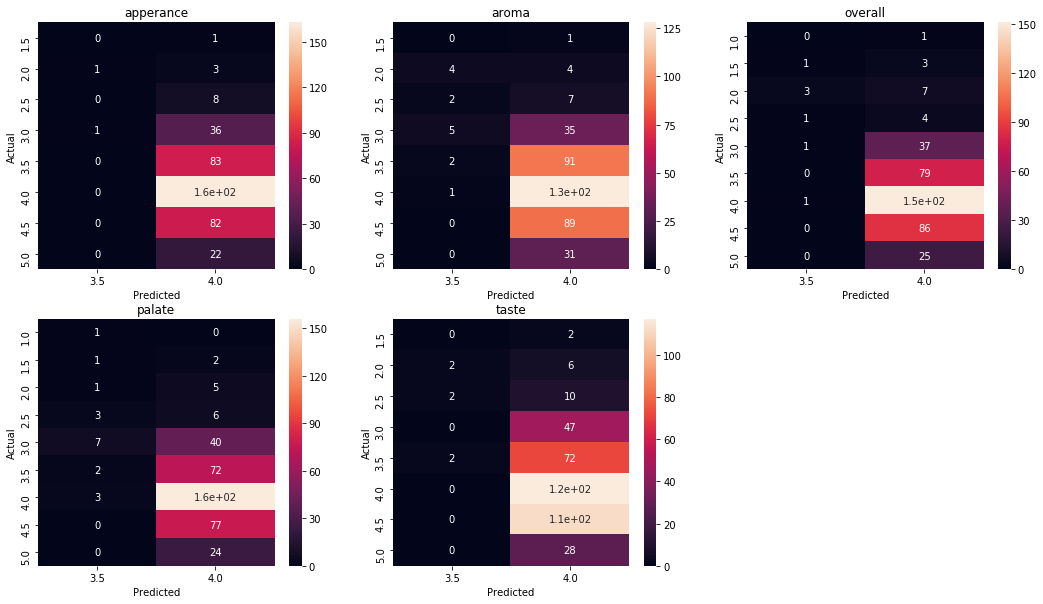

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18,10))
for i, (TRUE, data, desc) in enumerate(zip([TRUE_review_appearance, TRUE_review_aroma, TRUE_review_overall, TRUE_review_palate, TRUE_review_taste],
                         [apperance_preds, aroma_preds, overall_preds, palate_preds, taste_preds],
                         ['apperance', 'aroma', 'overall', 'palate', 'taste']), 1):
    plt.subplot(2,3,i)
    RESULT = pd.DataFrame({"True": TRUE, "Predict": data})
    confusion_matrix = pd.crosstab(RESULT["True"], RESULT["Predict"], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(confusion_matrix, annot=True)
    plt.title(desc)